# fit a baseline to the flattened spectra and apply barycentric velocity correction
### user should define a customized velocity range for each longitude in reduction_log.txt
#### 12/6/21 jpw

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import csv
import scipy as sp
from scipy.ndimage import median_filter
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
from astropy.coordinates import ICRS, LSR
import pandas as pd
%matplotlib inline

In [13]:
# function to calculate (additive) arycentric velocity correction to the data
def vbary(l, b, tobs):
    IfA_courtyard = EarthLocation(lat=21.3036944*u.deg, lon=-157.8116667*u.deg, height=372*u.m)
    t = Time(tobs, scale='utc')
    c = SkyCoord(l, b, frame='galactic', unit='deg')
    barycorr = c.radial_velocity_correction(kind='barycentric', obstime=t, location=IfA_courtyard)
    return barycorr.to(u.km/u.s).value

In [14]:
# change location of home drive
#os.chdir('/Volumes/GoogleDrive/My Drive/PD/RET2021/Data/2021-7-15')

path = '/Users/jpw/G/21cm_telescope/data_team2/'
date = '2021_12_01'
os.chdir(path+date)
cwd = os.getcwd()

In [20]:
# read in the reduction log which contains metadata on the observations
# use pandas for flexibility but it needs a bit of manipulation, e.g., stripping out whitespace from header
# NOTE that the timestamps from gnuradio need to be edited to replace the . between hms with :
df = pd.read_csv('reduction_log.txt')
df.columns = df.columns.str.strip()
nd = len(df)

In [21]:
df.columns

Index(['name', 'lon', 'lat', 'obstime', 'vlow', 'vhigh'], dtype='object')

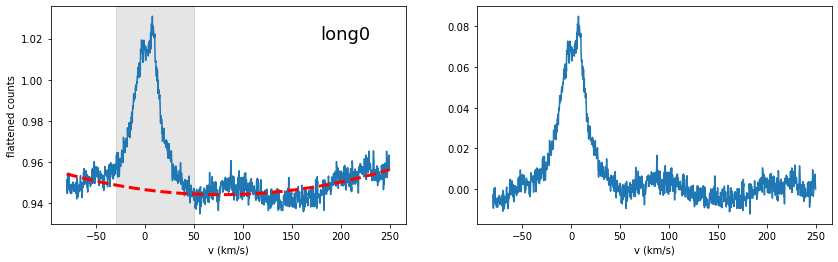

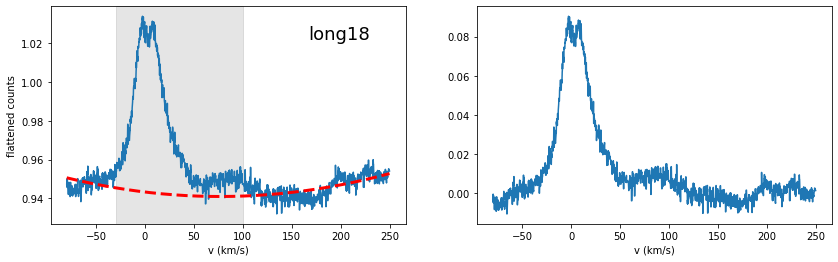

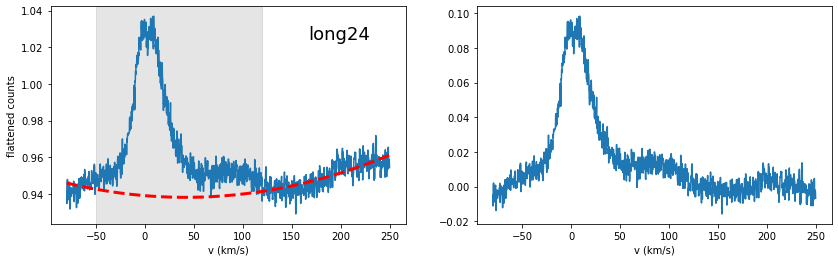

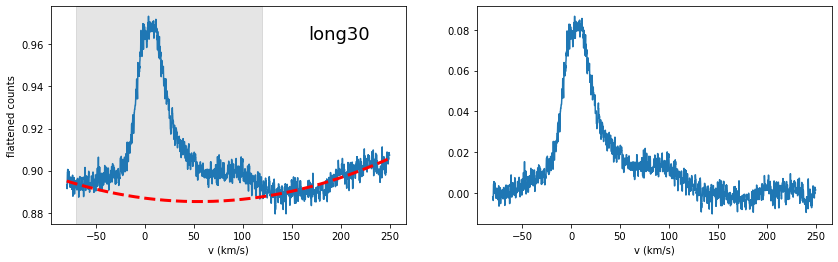

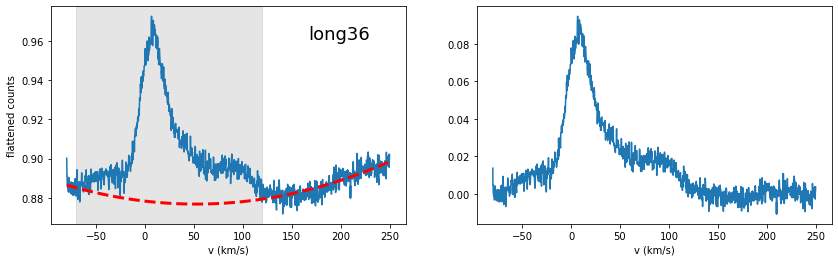

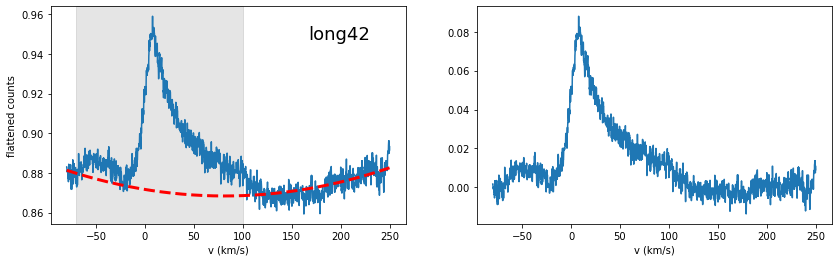

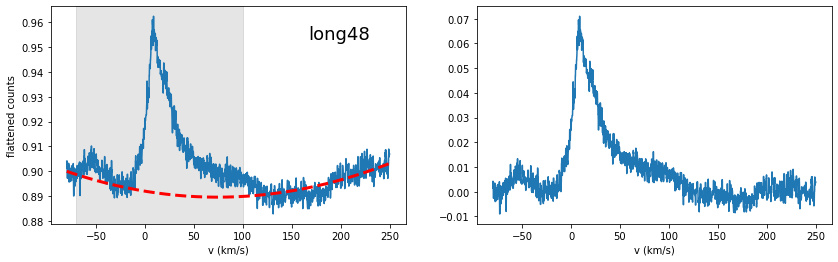

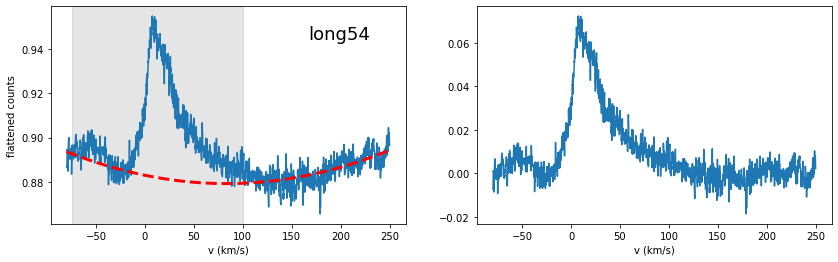

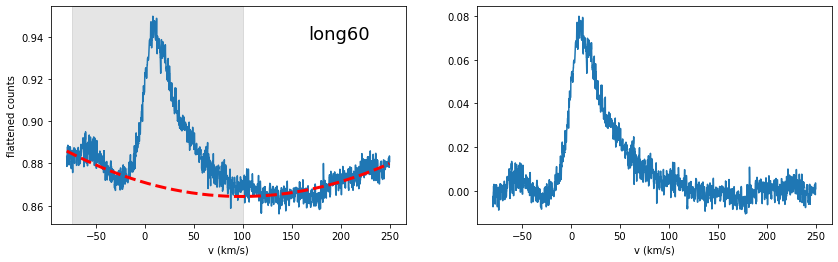

In [22]:
# look at the flattened data

# remove the bandpass edges defined in flatten_spectra.ipynb
vbpass_lo = -80
vbpass_hi = 250

for i in range(nd):
    iname = df['name'][i]
    f = 'flat/' + iname +'_flat.csv'
    v, Cf = np.genfromtxt(f, delimiter=',', unpack=True)
    
    bpass = (v > vbpass_lo) & (v < vbpass_hi)
    v = v[bpass]
    Cf = Cf[bpass]
    
    # user defined range where you see emission (edit reduction_log)
    vlo = df['vlow'][i]
    vhi = df['vhigh'][i]
    
    ibase = (v < vlo) + (v > vhi)
    order = 2
    p = np.polyfit(v[ibase], Cf[ibase], order)
    Cbase = np.polyval(p, v)

    fig = plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)
    ax1.plot(v, Cf)
    ax1.plot(v, Cbase, 'r--', lw=3)
    ax1.set_xlabel('v (km/s)')
    ax1.set_ylabel('flattened counts')
    ax1.text(0.9, 0.85, iname, fontsize=18, ha='right', transform=ax1.transAxes)
    ax1.axvspan(vlo, vhi, color='black', alpha=0.1)
    
    ax2 = fig.add_subplot(122)
    ax2.plot(v, Cf-Cbase)
    ax2.set_xlabel('v (km/s)')
    

long0 Barycentric correction =  -8.81 km/s, LSR correction =   9.00 km/s
Writing reduced spectrum to  long0_reduced.csv
long18 Barycentric correction = -13.05 km/s, LSR correction =  12.27 km/s
Writing reduced spectrum to  long18_reduced.csv
long24 Barycentric correction = -14.21 km/s, LSR correction =  13.10 km/s
Writing reduced spectrum to  long24_reduced.csv
long30 Barycentric correction = -15.23 km/s, LSR correction =  13.79 km/s
Writing reduced spectrum to  long30_reduced.csv
long36 Barycentric correction = -16.06 km/s, LSR correction =  14.33 km/s
Writing reduced spectrum to  long36_reduced.csv
long42 Barycentric correction = -16.74 km/s, LSR correction =  14.72 km/s
Writing reduced spectrum to  long42_reduced.csv
long48 Barycentric correction = -17.25 km/s, LSR correction =  14.94 km/s
Writing reduced spectrum to  long48_reduced.csv
long54 Barycentric correction = -17.54 km/s, LSR correction =  15.00 km/s
Writing reduced spectrum to  long54_reduced.csv
long60 Barycentric correct

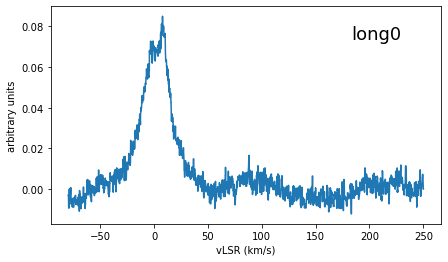

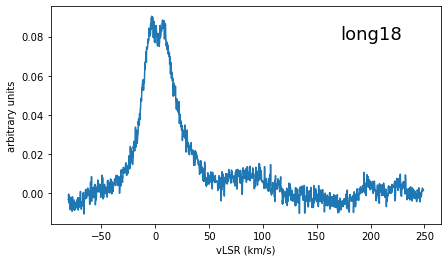

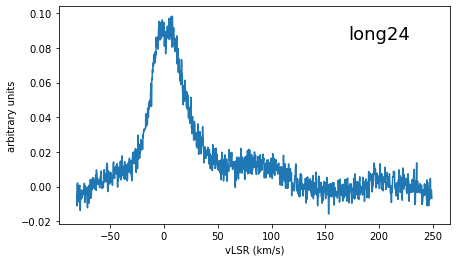

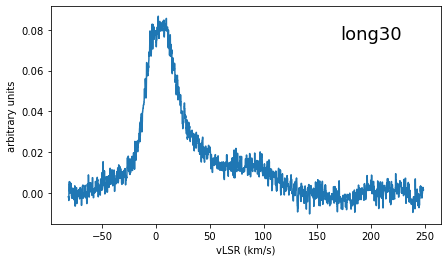

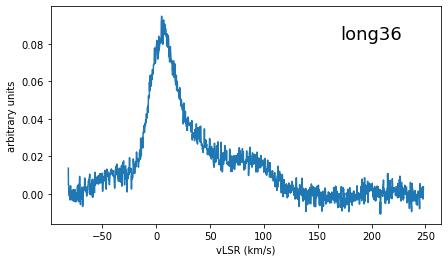

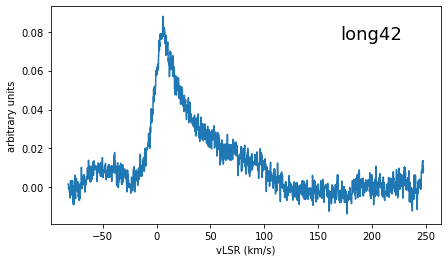

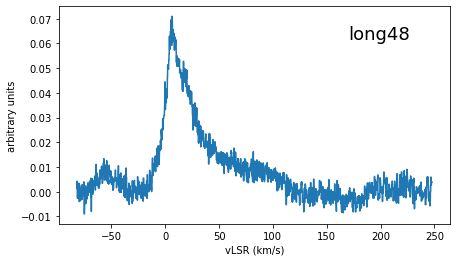

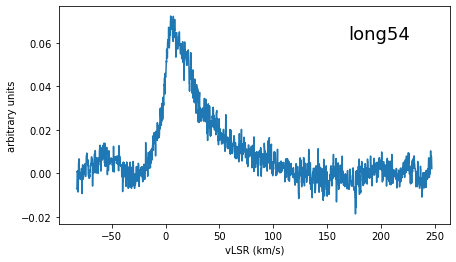

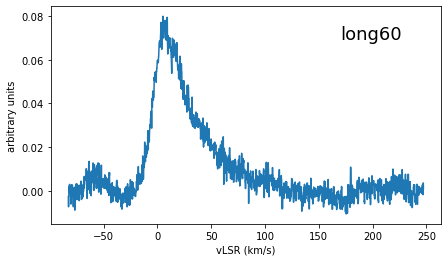

In [23]:
# if happy with the baseline for each spectrum
# make a barycentric correction and then convert to LSR and finally save the result
#### see https://public.nrao.edu/ask/velocity-reference-used-in-radio-astronomy/
#### and https://www.atnf.csiro.au/people/Tobias.Westmeier/tools_hihelpers.php#restframes)

reduced_subdir = 'reduced'
reduced_dir = cwd + '/' + reduced_subdir
# check to see if a "reduced" subdirectory exists, else make one
if not os.path.isdir(reduced_dir):
    print('Creating subdirectory', reduced_subdir, ' in ', cwd)
    os.mkdir(reduced_dir)

for i in range(nd):
    iname = df['name'][i]
    ff = 'flat/' + iname +'_flat.csv'
    v, Cf = np.genfromtxt(ff, delimiter=',', unpack=True)
    v = v[bpass]
    Cf = Cf[bpass]
    
    vlo = df['vlow'][i]
    vhi = df['vhigh'][i]   
    ibase = (v < vlo) + (v > vhi)
    order = 2
    p = np.polyfit(v[ibase], Cf[ibase], order)
    Cbase = np.polyval(p, v)
    
    l = df['lon'][i]
    b = df['lat'][i]
    tobs = df['obstime'][i].strip().replace('_',' ')
    vcorr1 = vbary(l, b, tobs)
    
    lrad = l * np.pi/180
    brad = b * np.pi/180
    vcorr2 = 9*np.cos(lrad)*np.cos(brad) + 12*np.sin(lrad)*np.cos(brad) + 7*np.sin(brad)
    vLSR = v + vcorr1 + vcorr2
    print('{0} Barycentric correction = {1:6.2f} km/s, LSR correction = {2:6.2f} km/s'.format(iname, vcorr1, vcorr2))

    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(111)
    ax.plot(vLSR, Cf-Cbase)
    ax.set_xlabel('vLSR (km/s)')
    ax.set_ylabel('arbitrary units')
    ax.text(0.9, 0.85, iname, fontsize=18, ha='right', transform=ax.transAxes)
    

    fr = iname+'_reduced.csv'
    print('Writing reduced spectrum to ', fr)
    with open(reduced_dir + '/' + fr, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(zip(vLSR, Cf-Cbase))
